In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import osmnx as ox
import networkx as nx
from sklearn.cluster import KMeans
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh
from matplotlib import pyplot as plt
np.random.seed(1)

## **Developing Community Typologies using Spectral Clustering: An analysis of the Atlanta Aerotropolis**
This project aims to determine how micro-mobility infrastructure produces social inequality within the [Atlanta Aerotropolis](https://aeroatl.org/), this research utilizes a machine learning approach to develop a series of community typologies. The physical boundaries of these communities are developed through an algorithm known as spectral clustering. Spectral clustering is a technique that is commonly used in graph analysis, which decomposes a graph (or network) into its most interconnected components. William Fleshman, in his article “Spectral Clustering: Foundation and Application” provides a potent visual example of how spectral clustering works:

<p style="text-align: center;">
<img src = figures/sc_example_1.png /> <img src = figures/sc_example_2.png> 
<br>
<em>Figure 1.0: Spectral clustering divides a graph into its most interconnected components.</em>
</p>

In the above example, the left and right sides of the graph are largely disconnected from one another; there is only one edge that connects the two components. Spectral clustering effectively identifies these two components, without any human intervention. In more technical language, spectral clustering works in three steps:
1.	Formulate the graph as a matrix, in which each element represents the number of edges (or connections between two distinct nodes) within the network. This is known as the adjacency matrix. Then, subtract this matrix from the degree matrix of the network (which is the number of connections from one node to all other nodes, for each node). This is the graph Laplacian.
2.	Perform eigen decomposition on the graph Laplacian. The z smallest eigenvalues correspond to the z most disconnected components within a graph.
3.	Perform k means clustering on the z eigenvectors from above.

According to the [Atlanta Aerotropolis Blueprint](https://aeroatl.org/blueprint/), the targeted area for development is within a 5-mile radius of the Hartsfield-Jackson International Airport. 
<p style="text-align: center;">
<img src = figures/study_area.png>
<br>
<em>Figure 1.1: Aerotropolis study area, taken from the <a href=https://aeroatl.org/blueprint>Atlanta Aerotropolis Blueprint</a></em>
</p>

This area contains the municipalities of East Point, College Park, Forest Park, Hapeville, alongside parts of Atlanta, Riverdale, and Lake City. These communities span across both Fulton and Clayton counties. In order to capture micro-mobility infrastructure for this analysis, Open Street Map was utilized. Open Street Map (OSM) is an open-source spatial data repository, which contains street, public transit, and natural feature data. Using the OSMnx package in Python, a street network was pulled that encapsulates the 5-mile radius around the airport. The final street network only contain roads which have some form of walking infrastructure, whether it be sidewalks or standalone pedestrian paths.

#### Pull Street Network Data via OSMnx

In [3]:
#Get center airport coords
coords = (33.638847,-84.428816)

#Get the street network for 5 miles within the airport
#Normally, this graph is multi-directed. However, in order to calculate the laplacian, we will convert it to a normal, undirected graph
G = ox.graph.graph_from_point(coords, dist = 8046.72, network_type = "walk").to_undirected()
#We will also remove self loops
G.remove_edges_from(nx.selfloop_edges(G))
#Lastly, update node labels so they are listed in sequential order
G = nx.convert_node_labels_to_integers(G)

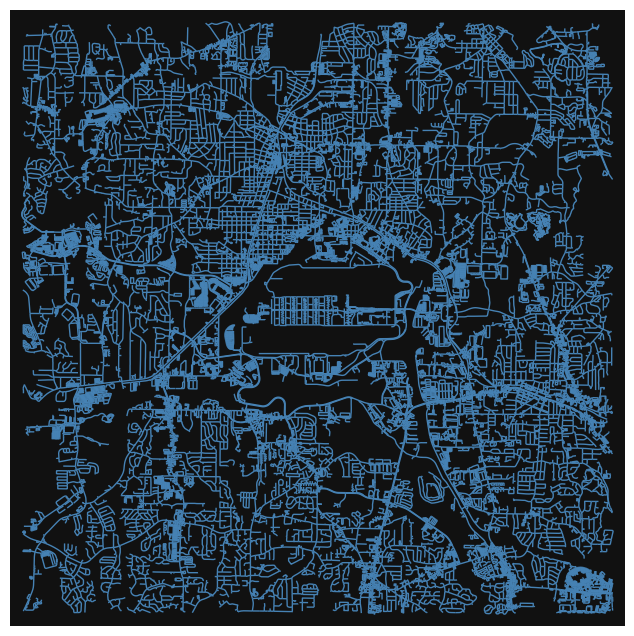

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [4]:
ox.plot.plot_graph(G, node_alpha = 0, edge_color = 'steelblue', save = True, filepath = 'streetgrid.png')

Spectral clustering was applied to the above network to identify its most interconnected components. One important question to answer when utilizing spectral clustering is the question of how many—what is an “ideal” number of interconnected components, or clusters, to use for analysis? Though there is no single best method to answer this question, there are several heuristics that one can use to determine a ‘good’ number of clusters. In the case of this project, an analysis of the eigenvalues from the graph Laplacian was utilized to select the ideal number of clusters. Since lower eigenvalues correspond to more “disconnected” components of the graph, you can utilize a plot to examine where the eigenvalues begin to increase rapidly, resulting in a loss of quality in the number of disconnected components. Through this analysis, 9 clusters were selected.

#### Retreive Spectral Decomposition of Graph Laplacian

In [5]:
#Get normalized graph laplacian
L = csr_matrix(nx.normalized_laplacian_matrix(G))

#Get first 200 eigenvectors from the normalized laplacian, then plot the scree plot
w,v = eigsh(L, k = 20, which = 'SM')

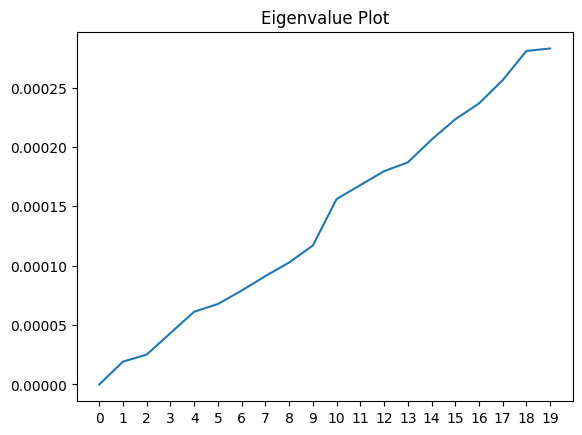

In [6]:
#Set axes
x = [a for a in range(20)]
y = w

#Plot eigenvalues
plt.title('Eigenvalue Plot')
plt.xticks(x)
plt.plot(x, y)


As shown in the above output, a 'kink' in the plot occurs at the ninth eigenvalue. This indicates that the first 9 eigenvectors of the spectral decomposition best explain the connectivity of the graph. Using this information, I perform spectral clustering on the street network with k = 9.

#### Perform Spectral Clustering

In [7]:
#Perform KMeans on the spectral decomposition where k = 9
#Initialize and fit model
km_spectral = KMeans(n_clusters = 9, n_init = 10).fit(v[:,:9])

#Map nodes to cluster labels
km_classes = {N:label for N,label in zip(G.nodes, km_spectral.labels_)}
#Map nodes to colors based on label class
colors = {0:'#32a852', 1:'#ab3830', 2:'#2b2ead', 3:'#bdb82f', 4:'#e67e00', 5:'#c621cc', 6:'#21ccbb', 7:'#481b96', 8:'#77961b'}
km_colors = {N:colors[label] for N,label in km_classes.items()}

#Assign labels back to nx object
nx.set_node_attributes(G, km_classes, 'clust_label')

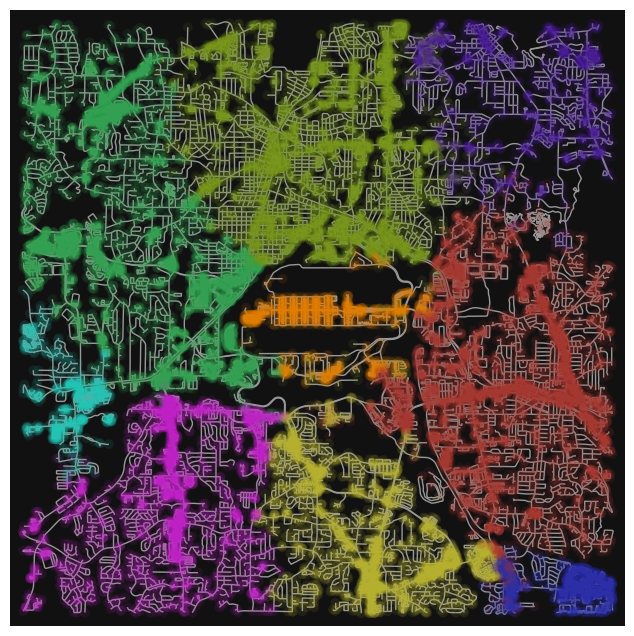

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [8]:
ox.plot.plot_graph(G, node_alpha = 0.1, node_size = 50, node_color = [c for c in km_colors.values()], save = True, filepath = 'cluststreetgrid.png')

The above figure represents the nine most interconnected components of the Aerotropolis walking street network. In other words, the experience of walking within a given region is relatively cohesive, but the experience of walking between these regions is predicated on few transition points. The most prominent observation is the isolation of the airport (in orange) with respect to other clusters. This should come as no surprise, since the airport is accessible strictly through the major highways of I-75 and State Route 403. Nonetheless, this stark isolation only supports the notion that the airport is very much an individual entity in urban space, with little to no integration with the surrounding cityscape. These regions do not restrict themselves to any formal borders or political designations. Rather, these regions are purely expressions of urban form, spaces in which an individual may feel a sense of familiarity, and on their fringes, a sense of confusion or disorientation. This notion of connectivity (or dysconnectivity) is best understood when plotting the major highways that run through the Aerotropolis region. Utilizing Georgia Department of Transportation data, the major state routes and highways surrounding the airport were visualized:

<p style="text-align: center;">
<img src = figures/cleaned_viz.png>
<br>
<em>Figure 2.0: Digitized regions from Figure 2.0, alongside major highways in the Aerotropolis region.</em>
</p>

Upon initial inspection, an observer can clearly see how many of these regions are delineated by major highways. The spectral clustering model had no knowledge of these roadways—the network included strictly pedestrian-friendly local roads. Nonetheless, the natural structure of the street network identified these highways as barriers. Why is this? A likely explanation is that the major roadways physically restrict the frequency of access points from one side to the other, hence limiting the overall connectivity of the network. Under the paradigm of urban ecology, we can understand these divisions as a Darwinian process: when physical barriers are placed, communities will evolve in isolation from one another. As James Corner suggests in his essay “Terra Fluxus”: “…the discipline of ecology suggests that individual agents acting across a broad field of operation produce incremental and cumulative effects that continually evolve the shape of an environment over time” (Corner 2005).  This isolated evolution becomes prevalent when we examine the boundaries between regions using Google Street View. The below image depicts Mt. Zion road, one of the few connection points that separates region 8 from region 7, the road above the tunnel is Interstate 75 (State Route 401):

<p style="text-align: center;">
<img src = figures/gsv_1.png /> <img src = figures/gsv_2.png> 
<br>
<em>Figure 2.1: Mt Zion road, a connection that crosses the border of regions 7 and 8. Region 8 on the left, region 7 on the right..</em>
</p>

Figure 2.1 depicts a stark contrast between the two regions. Region 7 is very exposed, with low tree coverage and high retaining walls. Region 8, just a few meters away, appears as a back country road, with unkempt sidewalks and lush vegetation. Clearly, the spatial divisions curated through the existence of I-75 have a very comprehensible impact on the presentation of space. These two regions, as a result of their physical disconnection, have developed distinct urban fabrics that have more or less grown in isolation from one another. Subsequently, the process of transitioning from region 8, a highly manufactured environment, to region 7, a natural environment, is not just a physical exercise, but a psychological one. 
Nonetheless, this transition does not simply embody the physical, but also the social. Just as the environment changes when crossing I-75, so too do the characteristics of the people who live there.

#### Social Analysis of Spectral Clustering Results

In order to better understand these social distinctions, I utilized American Community Survey 5-Year data to develop socioeconomic profiles for each of the clusters. This was achieved by exporting all the census tracts within the 5-mile study area, then performing a spatial join of the cluster boundaries with the census tracts. A census tract was joined with the cluster only if it was completely within the boundary of the cluster. Smaller clusters on the periphery of the study area were not large enough to contain any one single census tract and were subsequently excluded from analysis. Finally, after the spatial join was performed, a percentile ranking of each variable relative to the entire distribution of Georgia was calculated. This allows for a more absolute scoring of vulnerability. This analysis was performed in R, so I cannot include the code in this notebook, however the code used can be found in this github repository, entitled 'viz.rmd'. The following 9 ACS-5 variables were used in the analysis:
1.	Income disparity (Gini Index)
2.	Unemployment rate
3.	Percent population with a disability
4.	Median household income (USD)
5.	Percent population with no vehicle
6.	Average rent (USD)
7.	Percent of single parent households
8.	Percent of rent burdened households (households that spend over 30% of their monthly income on rent)

The below code identifies the tracts within each region, then performs a spatial join to attach the ACS-5 demographic data to the region boundaries. For all census tracts within a region, they are aggregated and the means of each demographic variable from above are calculated.

In [9]:
#Read in Census tracts
tracts = gpd.read_file('data/tracts.geojson')

#Spatial join tracts within search area
#Get edges gdf
edges = ox.graph_to_gdfs(G, nodes = False, edges = True)
#Get nodes gdf
nodes = ox.graph_to_gdfs(G, nodes = True, edges = False)
#Get edges bbox
bbox = edges.total_bounds

#Clip tracts
tracts = gpd.clip(tracts, bbox)

c:\Users\Sam\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\tools\clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [10]:
#Spatial join regions with tracts
#Read in regions
regions = gpd.read_file('data/regions.shp').to_crs('EPSG:4269')
regions['neighborhood_id'] = regions['neighborho']
regions.drop('neighborho',axis=1,inplace=True)

#Intersect with tracts and filter columns
join = gpd.sjoin(regions,tracts,how = 'left',predicate='contains')

join.drop(['Shape_Leng','Shape_Area','index_right','GEOID','NAME','geometry'], axis = 1,inplace = True)

#Group by and take means
data = join.groupby('neighborhood_id').mean().reset_index()
data = regions.join(data, on = 'neighborhood_id', how = 'left',lsuffix='_r')

data.to_file('data/joined_data.shp')

C:\Users\Sam\AppData\Local\Temp\ipykernel_43060\4264393795.py:16: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  data.to_file('data/joined_data.shp')


The exported joined_data.shp file was used in R to create a series of visualizations outlining the socioeconomic state of the spectral clustering regions. Here are some of those results:

<p style="text-align: center;">
<img src = figures/disability.png /> <img src = figures/rentburden.png> 
<br>
<img src = figures/novehicle.png /> <img src = figures/gini.png> 
<br>
<em>Figure 3.0: Some of the socio-economic characteristics of the regions, from top left moving clockwise: percent with disability, precent with no vehicle, income disparity, and percent rent burdened. Data is not presented in its raw format, but rather its percentile relative to the state distribution for each variable.</em>
</p>

Examining the above figure yields some interesting observations. Most notably is the high prevalence of a careless population within region 7. This region is within the 90th percentile in carless rates relative to the rest of the state. Furthermore, region 7, which is the only portion of the Aerotropolis area within Atlanta proper, is also characterized by high income disparity, low median home value, and high unemployment. This area stands in stark contrast to region 1 to its south, which has the lowest percent of careless population in the entire Aerotropolis area, alongside very low unemployment. These two regions, which Interstate 285 bisects, exhibit not just physical dysconnectivity as identified by the spectral clustering analysis, but also exhibit stark social distinctions, which themselves have manifested as a result of such dysconnectivity. 

Furthermore, these regions display important information about spatial trends of social inequity in the Aerotropolis region. More specifically, there is a notable divide between north and south. Generally, regions 3 and 5, which contain portions of both Fulton and Clayton counties, exhibit the lowest income disparity, alongside the highest median income within the entire Aerotropolis study area. These regions, which are segregated from the rest of the Aerotropolis study area via I-285 to their north and I-75 to their west, again underscore the notion of independent community typologies as a result of street dysconnectivity. In the same way that Mt. Zion Road bridges the physical divide of two urban spaces, so too does it bridge two distinctly unique communities, with their own needs, characteristics, and desires.

<p style="text-align: center;">
<img src = figures/table.png />
<br>
<em>Figure 3.1: Table of socio-economic characteristics for each spectral clustering region.</em>
</p>

#### Conclusion
The central aim of this research is to introduce a novel methodology for characterizing urban space. As demonstrated, this spectral clustering method not only reveals the physical contours that demarcate and divide urban districts, but also pinpoints the un-seen boundaries that produce social inequality. Within the context of the Aerotropolis, understanding these community typologies is critical. If indeed the Aerotropolis Alliance wishes to “…align the metropolitan region to better leverage an airport’s assets and provide a framework for the strategic planning and development of economic activity and real estate”, then it must first understand the notion of urban orientation and organized complexity. The region surrounding the airport is, not unlike the human body, an organism. The proposal of the Aerotropolis, as noble as it may be, will have tangible effects on the health of this organism. Infrastructure plays a critical role in determining the health of the Aerotropolis region. As James Corner explains:

>Unlike architecture, which consumes the potential of a site in order to project, urban infrastructure sows the seeds of future possibility, staging the ground for both uncertainty and promise. This preparation of surfaces for future appropriation differs from merely formal interest in single surface construction. It is much more strategic, emphasizing means over ends and operational logic over compositional design (Corner 2005).

Indeed, infrastructure is a treatment just as much as it is an illness. The same mechanisms through which segregate the urban fabric can also unite it. The employment of spectral clustering allows us to see how micro-mobility can create very different community typologies. However, this is simply a diagnosis. The actual treatment should be left within the hands of the community, those who best understand the urban fabric, alongside the structures and flows that embody their home. Any other course of action would be a disservice to the tenets of the Aerotropolis.
